In [139]:
import keras
import numpy as np
import os
import scipy.io as sio
import scipy.signal as ssi
import sys
sys.path.append("../../../ecg")

import util

In [2]:
model_path = "/deep/group/awni/ecg_models/default/1527627404-9/0.337-0.880-012-0.255-0.906.hdf5"
data_path = "/deep/group/med/alivecor/training2017/"

SAMPLE_RATE = 300

records = load_all(data_path)

In [3]:
preproc = util.load(os.path.dirname(model_path))
model = keras.models.load_model(model_path)

(6000,)


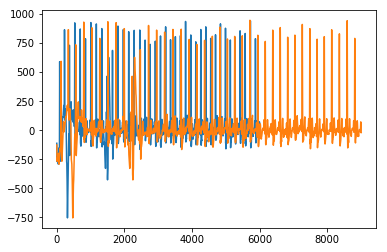

In [151]:
nx = ssi.resample(records[0][0], int((2 / 3.) * records[0][0].shape[0]))
plt.plot(nx)
print nx.shape
plt.plot(records[0][0])
#print records[0][0].shape[0]

In [155]:
ecgs = []; labels = []
for ecg, label in records:
    if ecg.shape[0] > 8832:
        start = int((ecg.shape[0] - 8832) / 2)
        ecgs.append(ecg[start:start+8832]) # TODO take the middle?
        labels.append(label)

ecgs = ssi.resample(np.stack(ecgs), 5888, axis=1)


In [160]:
x = ecgs.copy()
mean, std = np.mean(x), np.std(x)
x = ((x - mean) / std).astype(np.float32)
x = x[:,:,None]
preds = model.predict(x, verbose=1)

7568/7568 [==============================] - 14s 2ms/step


In [163]:
cinc17_classes =  {'A' : 0, '~' : 1, 'N' : 2, 'O' : 3}
AF = preds[...,0]
NOISE = preds[..., 6]
SINUS = preds[..., 7]
OTHER = np.sum(preds[..., 1:6], axis=2) + np.sum(preds[..., 8:], axis=2)
preds = np.stack([AF, NOISE, SINUS, OTHER], axis=2)

In [164]:
def get_predictions(preds):
    # preds is [example x time x classes]
    modes, counts = ss.mode(np.argmax(preds, axis=2), axis=1)
    return modes.squeeze()
    # Two possible strategies here:
    # 1. Vote for the best label
    # 2. Just take A if A ocurrs
    #    otherwise take O
    #    otherwise take N
    #    otherwise take ~

predictions = get_predictions(preds)
ground_truth = [cinc17_classes[l] for l in labels]
print np.sum(predictions == ground_truth) / float(len(ground_truth))

0.6724365750528541


In [165]:
import sklearn.metrics as skm
report = skm.classification_report(
            ground_truth, predictions,
            target_names=['A', '~', 'N', 'O'],
            digits=3)
print(report)

             precision    recall  f1-score   support

          A      0.654     0.853     0.741       648
          ~      0.322     0.832     0.465       143
          N      0.694     0.950     0.802      4557
          O      0.750     0.041     0.077      2220

avg / total      0.700     0.672     0.578      7568



2 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 2


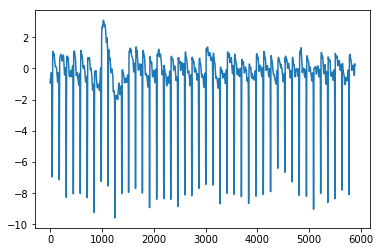

In [181]:
idx = 38
print predictions[idx], np.argmax(preds, axis=2)[idx,...], ground_truth[idx]
plt.plot(x[idx].squeeze())